In [50]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
import os

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
# Global Variables setting

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
PATCH_SIZE = 16
EMBEDDING_DIM = 786

In [53]:
# Training and testing directory setup

train_dir = "C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/train"
test_dir = "C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/test"


In [54]:
# Creating DataLoader

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def createDataLoaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):
    
    # Using image folder to create datasets
    trainingData = datasets.ImageFolder(train_dir, transform=transform)
    testingData = datasets.ImageFolder(test_dir, transform=transform)

    # Getting class names
    classes = trainingData.classes

    # Images to dataloaders
    trainingDataLoader = DataLoader(
        trainingData,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    testingDataLoader = DataLoader(
        testingData,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return trainingDataLoader, testingDataLoader, classes

In [55]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [56]:
# Creating dataloaders

trainingDataLoader, testingDataLoader, classNames = createDataLoaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

trainingDataLoader, testingDataLoader, classNames

(<torch.utils.data.dataloader.DataLoader at 0x1a7f25ef740>,
 ['-1', '0', '1', '2'])

Label:  tensor(3)


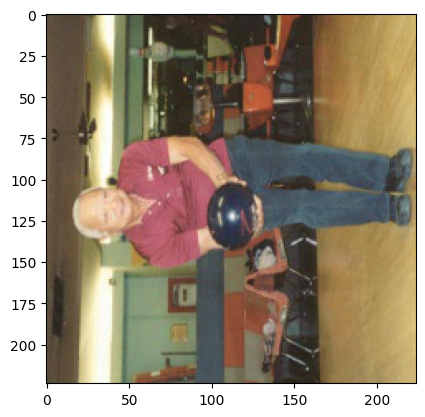

In [57]:
# Sample test

imageBatch, labelBatch = next(iter(trainingDataLoader))

firstImage, firstLabel = imageBatch[0], labelBatch[0]

print("Label: ", firstLabel)
plt.imshow(firstImage.permute(1,2,0))

In [58]:
trainingDataLoader.__len__() # 290*32 = 9280 images

290

In [59]:
firstImage.shape

torch.Size([3, 224, 224])

In [60]:
# 1. Creating a patch, Flatten patch, Convert 2d patch to 1d embedding
# 16*16*3 = 768 (Every path's final dim after flattening)

class PatchEmbedding(nn.Module):

    def __init__(self, in_channel: int=3, patch_size:int=16, embedding_dim: int=768):
        super().__init__()
    
        self.patchLayer = nn.Conv2d(in_channels=in_channel, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.patchSize = patch_size
        self.flattenLayer = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        assert x.shape[-1] % self.patchSize == 0, f"The given input image size is not compatible with the patch size. Image size: {x.shape[-1]}, Patch size: {PATCH_SIZE}"

        print("Image Shape: ", x.shape)
        imagePatch = self.patchLayer(x)
        print("Image Patch Shape: ", imagePatch.shape)
        imageFlatten = self.flattenLayer(imagePatch)
        print("Flattened Image: ", imageFlatten.shape)

        return imageFlatten.permute(0, 2, 1)

In [61]:
# Multi head self attention block

class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int=768, no_of_heads: int=12, attention_dropout: float=0):
        super().__init__()

        self.normalizationLayer = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multiHeadAttention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=no_of_heads, dropout=attention_dropout, batch_first=True)

    def forward(self, x):
        x = self.normalizationLayer(x)
        attentionResult, _ = self.multiHeadAttention(query=x, key=x, value=x)
        return attentionResult

In [62]:
# Multi Layer Perceptron block

class MLPLayer(nn.Module):
    def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: float=0.1):
        super().__init__()

        self.normalizationLayer = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.normalizationLayer(x)
        x = self.mlp(x)
        return x

In [63]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 embedding_dim: int=768,
                 no_of_heads: int=12,
                 attention_dropout: float=0,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1,
                 ):
        super().__init__()

        self.multiHeadSelfAttention = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim, no_of_heads=no_of_heads, attention_dropout=attention_dropout)
        self.mlpLayer = MLPLayer(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):

        x = self.multiHeadSelfAttention(x) + x
        x = self.mlpLayer(x) + x
        return x

In [64]:
class VisionTransformer(nn.Module):

    def __init__(self, 
                 img_size: int=224,
                 in_channel: int=3,
                 patch_size: int=16,
                 no_of_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 no_of_heads: int=12,
                 attention_droupout: float=0,
                 mlp_dropout: float=0.1,
                 embedding_droupout: float=0.1,
                 no_of_classes: int=4):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be compatible with patch size. Image size is {img_size} and patch size is {patch_size}"

        self.no_of_patches = int((img_size  * img_size)/patch_size**2)
        self.classTokenEmbedding = nn.Parameter(torch.rand(1, 1, embedding_dim), requires_grad=True)
        self.patchEmbedding = PatchEmbedding(in_channel=in_channel, patch_size=patch_size, embedding_dim=embedding_dim)
        self.positionEmbedding = nn.Parameter(torch.rand(1, self.no_of_patches +1, embedding_dim), requires_grad=True)

        self.embeddingDropout = nn.Dropout(p=embedding_droupout)
        self.encoderLayer = nn.Sequential(*[EncoderLayer(embedding_dim=embedding_dim, no_of_heads=no_of_heads, mlp_size=mlp_size, mlp_dropout=mlp_dropout) for _ in range(no_of_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=no_of_classes)
        )
    
    def forward(self, x):

        batch_size = x.shape[0]
        x = self.patchEmbedding(x)
        classTokens = self.classTokenEmbedding.expand(batch_size, -1, -1)
        x = torch.cat((classTokens, x), dim=1)
        x = self.positionEmbedding + x
        x = self.embeddingDropout(x)
        x = self.encoderLayer(x)
        x = self.classifier(x[:, 0])
        return x


In [65]:
transformerInstance = VisionTransformer(no_of_classes=len(classNames))

In [66]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def singeTrainingStep(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              optimizer: torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
    
    model.train()

    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def singeTestingStep(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    model.eval() 

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def pytorchModelTraining(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []
    }
    
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = singeTrainingStep(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = singeTestingStep(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [67]:
optimizer = torch.optim.Adam(params=transformerInstance.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

lossFunction = torch.nn.CrossEntropyLoss()


results = pytorchModelTraining(model=transformerInstance,
                       train_dataloader=trainingDataLoader,
                       test_dataloader=testingDataLoader,
                       optimizer=optimizer,
                       loss_fn=lossFunction,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([3

 10%|█         | 1/10 [05:42<51:18, 342.08s/it]

Epoch: 1 | train_loss: 1.5240 | train_acc: 0.2510 | test_loss: 1.4032 | test_acc: 0.2489
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 20%|██        | 2/10 [13:20<54:41, 410.23s/it]

Epoch: 2 | train_loss: 1.3902 | train_acc: 0.2437 | test_loss: 1.3862 | test_acc: 0.2549
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 30%|███       | 3/10 [20:57<50:23, 431.89s/it]

Epoch: 3 | train_loss: 1.3864 | train_acc: 0.2539 | test_loss: 1.3863 | test_acc: 0.2528
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 40%|████      | 4/10 [28:27<43:53, 438.89s/it]

Epoch: 4 | train_loss: 1.3864 | train_acc: 0.2483 | test_loss: 1.3862 | test_acc: 0.2549
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 50%|█████     | 5/10 [35:53<36:48, 441.67s/it]

Epoch: 5 | train_loss: 1.3864 | train_acc: 0.2500 | test_loss: 1.3862 | test_acc: 0.2548
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 60%|██████    | 6/10 [43:13<29:23, 440.90s/it]

Epoch: 6 | train_loss: 1.3863 | train_acc: 0.2503 | test_loss: 1.3862 | test_acc: 0.2549
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 70%|███████   | 7/10 [50:36<22:05, 441.78s/it]

Epoch: 7 | train_loss: 1.3864 | train_acc: 0.2487 | test_loss: 1.3863 | test_acc: 0.2547
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 80%|████████  | 8/10 [56:18<13:39, 409.97s/it]

Epoch: 8 | train_loss: 1.3864 | train_acc: 0.2515 | test_loss: 1.3862 | test_acc: 0.2548
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

 90%|█████████ | 9/10 [1:01:49<06:25, 385.11s/it]

Epoch: 9 | train_loss: 1.3864 | train_acc: 0.2521 | test_loss: 1.3863 | test_acc: 0.2528
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([32, 768, 14, 14])
Flattened Image:  torch.Size([32, 768, 196])
Image Shape:  torch.Size([32, 3, 224, 224])
Image Patch Shape:  torch.Size([3

100%|██████████| 10/10 [1:07:25<00:00, 404.54s/it]

Epoch: 10 | train_loss: 1.3864 | train_acc: 0.2498 | test_loss: 1.3862 | test_acc: 0.2526


In [68]:
classes2text = {
    "-1": "No rotation",
    "0" : "90 degree clockwise rotated",
    "1": "180 degree clockwise rotated",
    "2": "270 degree clockwise rotated"
}

In [69]:

import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import zipfile
from pathlib import Path
import requests
import os



def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
   
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})


def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image / 255.0

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)

        target_image_pred = model(target_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    ) 
    if class_names:
        title = f"Prediction: {classes2text[class_names[target_image_pred_label.cpu()]]} (Prob: {target_image_pred_probs.max().cpu():.3f})"
    else:
        title = f"Prediction: {target_image_pred_label} (Prob: {target_image_pred_probs.max().cpu():.3f})"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

Image Shape:  torch.Size([1, 3, 224, 224])
Image Patch Shape:  torch.Size([1, 768, 14, 14])
Flattened Image:  torch.Size([1, 768, 196])


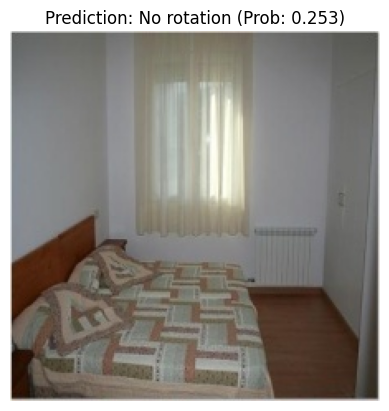

In [70]:

pred_and_plot_image(model=transformerInstance, image_path="C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/val/-1/375.jpg", class_names=classNames)

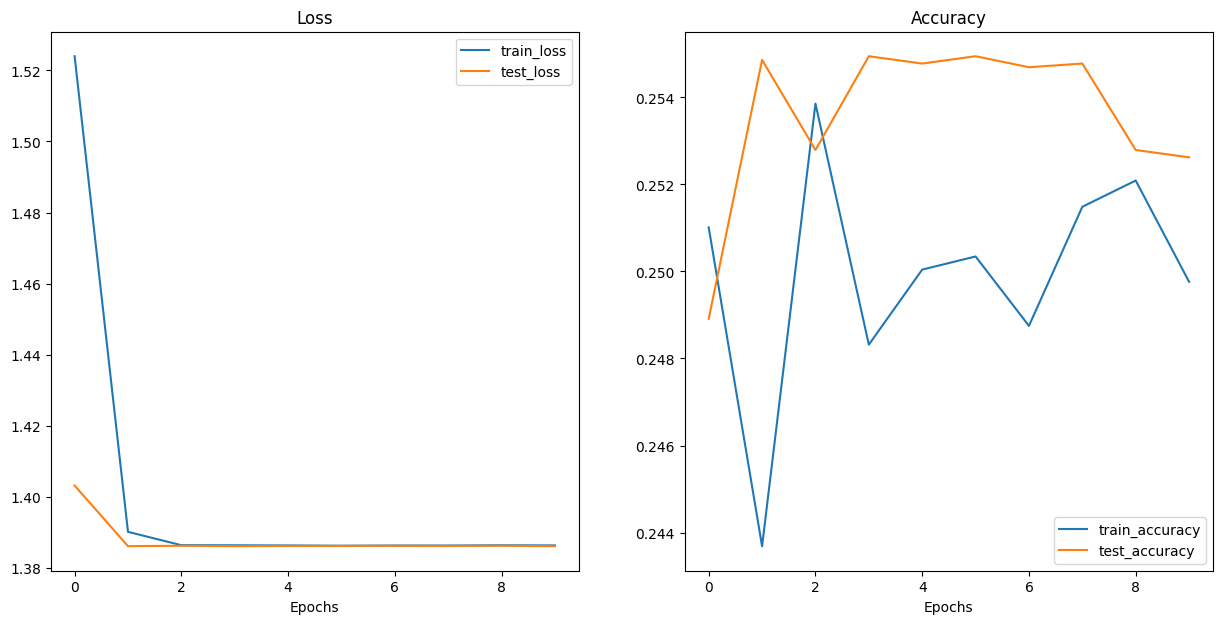

In [71]:
plot_loss_curves(results)

PRETRAINED TRANSFORMER

In [72]:
pretrainedWeights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
pretrainedTransformer = torchvision.models.vit_b_16(weights=pretrainedWeights).to(device)

In [73]:
for parameter in pretrainedTransformer.parameters():
    parameter.requires_grad = False

classNames = os.listdir("C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/train")

pretrainedTransformer.heads = nn.Linear(in_features=768, out_features=len(classNames)).to(device)

In [74]:
# Global Variables setting

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
PATCH_SIZE = 16
EMBEDDING_DIM = 786

In [75]:
# Training and testing directory setup

train_dir = "C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/train"
test_dir = "C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/test"

In [76]:
pretrainedTransformerTransforms = pretrainedWeights.transforms()
print(pretrainedTransformerTransforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [77]:
optimizer = torch.optim.Adam(params=pretrainedTransformer.parameters(),
                             lr=3e-3)

lossFunction = torch.nn.CrossEntropyLoss()

results = pytorchModelTraining(model=pretrainedTransformer,
                       train_dataloader=trainingDataLoader,
                       test_dataloader=testingDataLoader,
                       optimizer=optimizer,
                       loss_fn=lossFunction,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [03:12<28:56, 192.95s/it]

Epoch: 1 | train_loss: 0.8200 | train_acc: 0.6099 | test_loss: 0.6972 | test_acc: 0.6448


 20%|██        | 2/10 [06:23<25:33, 191.74s/it]

Epoch: 2 | train_loss: 0.6507 | train_acc: 0.6841 | test_loss: 0.6623 | test_acc: 0.6645


 30%|███       | 3/10 [09:34<22:18, 191.27s/it]

Epoch: 3 | train_loss: 0.6086 | train_acc: 0.7024 | test_loss: 0.6538 | test_acc: 0.6733


 40%|████      | 4/10 [12:45<19:05, 190.95s/it]

Epoch: 4 | train_loss: 0.5780 | train_acc: 0.7197 | test_loss: 0.6793 | test_acc: 0.6567


 50%|█████     | 5/10 [15:54<15:52, 190.45s/it]

Epoch: 5 | train_loss: 0.5619 | train_acc: 0.7283 | test_loss: 0.6566 | test_acc: 0.6681


 60%|██████    | 6/10 [19:03<12:39, 189.84s/it]

Epoch: 6 | train_loss: 0.5572 | train_acc: 0.7281 | test_loss: 0.6550 | test_acc: 0.6766


 70%|███████   | 7/10 [22:10<09:27, 189.04s/it]

Epoch: 7 | train_loss: 0.5480 | train_acc: 0.7326 | test_loss: 0.6580 | test_acc: 0.6688


 80%|████████  | 8/10 [25:17<06:16, 188.28s/it]

Epoch: 8 | train_loss: 0.5356 | train_acc: 0.7369 | test_loss: 0.6615 | test_acc: 0.6722


 90%|█████████ | 9/10 [28:22<03:07, 187.41s/it]

Epoch: 9 | train_loss: 0.5326 | train_acc: 0.7409 | test_loss: 0.6801 | test_acc: 0.6739


100%|██████████| 10/10 [31:27<00:00, 188.73s/it]

Epoch: 10 | train_loss: 0.5214 | train_acc: 0.7417 | test_loss: 0.6969 | test_acc: 0.6797


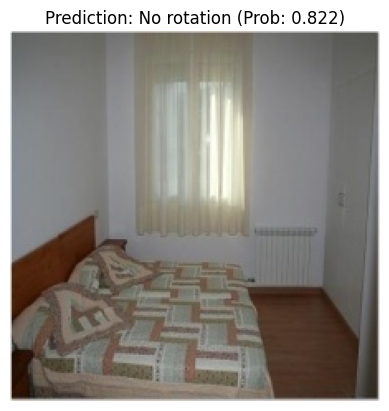

In [78]:
pred_and_plot_image(model=pretrainedTransformer, image_path="C:/Users/Lenovo/Documents/Python Scripts/archive/Final_split_data/val/-1/375.jpg", class_names=classNames)

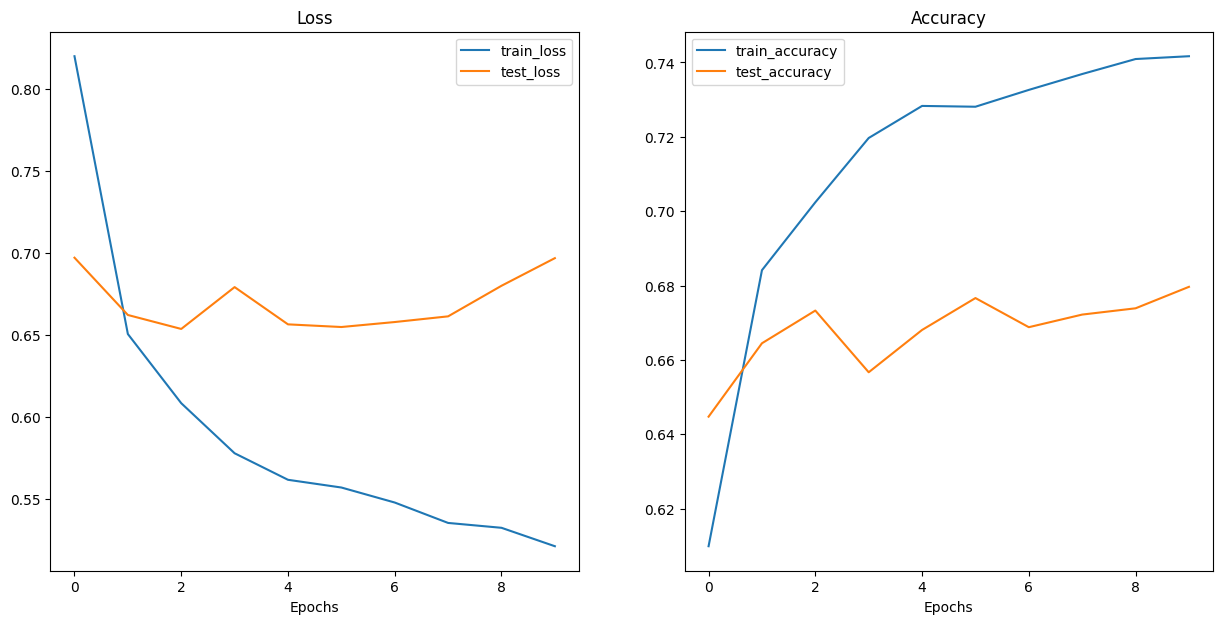

In [79]:
plot_loss_curves(results)